# Librerías

In [237]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report 
from sklearn.datasets import make_classification  

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras import regularizers  
from keras import backend as K 

import pickle

# Importar imágenes

## Funciones

In [2]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        artists.append(art)

        
    return images_all, artists

In [3]:
def muestra(bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Alto: {bd[num].shape[0]} px.')
    print(f'Ancho: {bd[num].shape[1]} px.')
    print(f'Profundidad: {bd[num].shape[2]} (RGB)')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

Aplicando la función <code>open_images_names</code> obtendremos las imágenes a analizar junto con una lista con los nombres que se extraen del archivo, lo unico que tenemos que pasarle a la función es la dirección del directorio donde están nuestras imagenes junto con <k>/**</k> para que nos extraiga todos los archivos que hay dentro.

In [4]:
images, artists = open_images_names("images/**")

Echaremos un primer vistazo a la estructura que tiene nuestros inputs.

In [5]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Michelangelo, Francisco Goya o Salvador Dali.


Con la función <code>muestra</code> podemos ver imágenes de nuestra colección junto con el nombre del artista y el tamaño. Cada vez que se ejecute saldrá una diferente.

Autor: Camille Pissarro
Dimensión:(614, 767, 3)
Alto: 614 px.
Ancho: 767 px.
Profundidad: 3 (RGB)


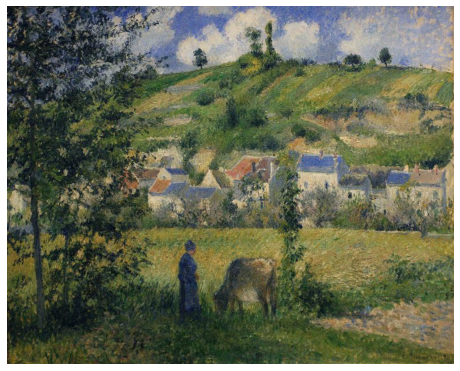

In [6]:
muestra(images)

# Corregir problemas de balanceo

## Funciones

In [37]:
def top_artists(df, y, num):
    
    """
    **************************************************************
    
    Divide la información en dos datasets diferentes usando la media
    del total de observaciones por categorías como separación.
    
    Input:
    df: dataframe a separar.
    y: variable dependiente.
    
    Output:
    *big_df: dataframe con las categorías con más observaciones.
    *small_df: dataframe con las categorías con menos observaciones.
    
    ***************************************************************
    """
    
    # Crea dos listas, una con las etiquetas de categoría con más observaciones
    # observaciones y la otra con las que tienen menos.
    
    c = list(df['artist'].value_counts()[num:].index)
            
    # Crea los dos dataframes tomando el original y agrupando según las categorías
    # listadas en el paso anterior
            
    big_df = []
    for i in c:
        big_df.extend(np.array(df[df[y] == i]))
    big_df = pd.DataFrame(big_df, columns = df.columns)

            
    return big_df

In [6]:
def visualice(df_big, df_small):
    
    """
    **************************************************************
    
    Muestra dos barplots con los artistas que se han separado.
    
    Input:
    df_big: dataframe con los artistas con más cuadros.
    df_small: dataframe con los artistas con menos cuadros.
    
    Output:
    * Barplots con ambas distribuciones
    
    ***************************************************************
    """

    print(f' El tamaño original es de {df_big.shape}. A partir de ahora trabajarás con {df_small.shape}.')
          
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(121)
    plt.title('Dataset original', fontsize=14)
    artists_plot1 = sns.countplot(df_big['artist'], palette="ch:.25")
    _=artists_plot1.set_xticklabels(artists_plot1.get_xticklabels(), rotation=65, horizontalalignment='right')
    fig.add_subplot(122)
    
    plt.title('Nueva selección', fontsize=14)
    artists_plot2 = sns.countplot(df_small['artist'], palette="ch:.25")
    _=artists_plot2.set_xticklabels(artists_plot2.get_xticklabels(), rotation=65, horizontalalignment='right')

In [7]:
def countplot_df(df, col):
    
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], palette="ch:.25")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

Generaremos una estructura de DataFrame para poder corregir los problemas de desbalanceo que hemos visto. Hacemos el cambio de estructura desde nuestras imágenes.

In [8]:
df = pd.DataFrame(images, columns = ['images'])

Añadimos la columna con los nombres de los artistas.

In [9]:
df['artist'] = artists

Echamos un vistazo al DataFrame creado para ver la estructura que sigue

In [10]:
df.head()

,images,artist
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian


Podemos observar como disponemos de más de 800 cuadros de Van Gogh, frente a los sobre 50 de Cezanne. Hay diferentes estrategias que podemos seguir llegados a este punto:
* Empezaremos probando con una selección de artistas que tengan el número de obras más balanceadas.

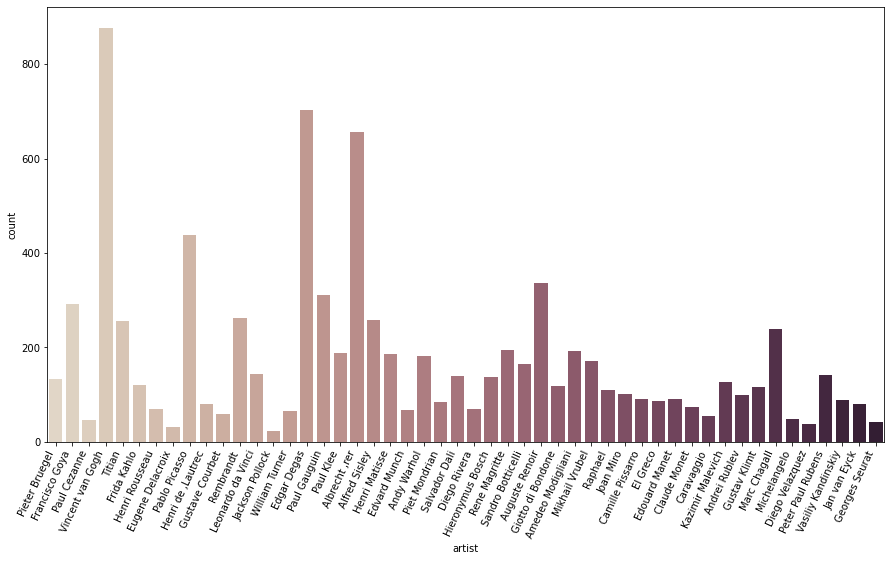

In [11]:
countplot_df(df, 'artist')

Usaremos la función <code>subsample_mean</code> que hemos creado para dividir el dataset en dos y quedarnos solo con los cuadros de los artistas que tengamos más cantidad de información que la media.

In [38]:
version1 = top_artists(df, 'artist', -10)

Dataset original vs dataset con la selección.
 El tamaño original es de (8683, 2). A partir de ahora trabajarás con (478, 2).


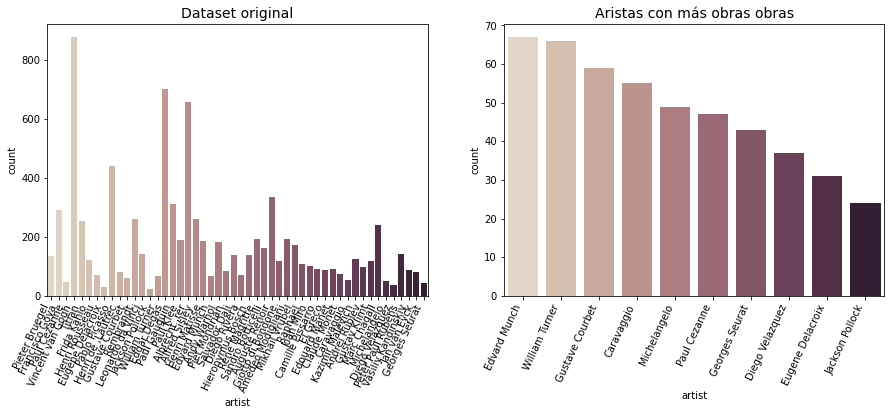

In [39]:
print("Dataset original vs dataset con la selección.")
visualice(df, version1)

In [16]:
version1.head()

,images,artist
0,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
1,"[[[230, 218, 116], [217, 208, 104], [218, 212,...",Vincent van Gogh
2,"[[[175, 225, 231], [191, 240, 248], [180, 230,...",Vincent van Gogh
3,"[[[42, 147, 198], [82, 187, 238], [100, 208, 2...",Vincent van Gogh
4,"[[[37, 87, 105], [47, 99, 116], [97, 147, 169]...",Vincent van Gogh


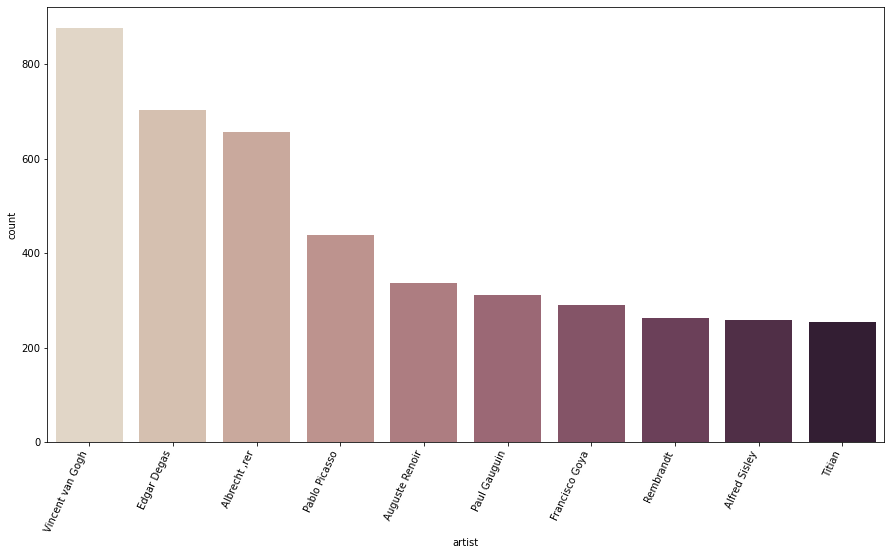

In [11]:
countplot_df(version1, 'artist')

# Separar train/test

In [40]:
images_v1=np.asarray(version1['images'])
artists =version1['artist']

In [41]:
num_classes = len(pd.unique(artists))

In [42]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [43]:
artists_dict

{2: 'Edvard Munch',
 9: 'William Turner',
 5: 'Gustave Courbet',
 0: 'Caravaggio',
 7: 'Michelangelo',
 8: 'Paul Cezanne',
 4: 'Georges Seurat',
 1: 'Diego Velazquez',
 3: 'Eugene Delacroix',
 6: 'Jackson Pollock'}

In [44]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [45]:
#Esto convierte a OneHotEncoding

y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = np_utils.to_categorical(y_test_original, num_classes)
#y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

# Ajustar el tamaño de las imágenes

## Funciones

In [46]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imágen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [47]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

Las imágenes que forman nuestra clección tienen diferentes tamaños, deberemos establecer un tamaño común para todas para poder entrenar nuestro algoritmo.

In [209]:
dim = (100, 100)

In [210]:
x_train_resized = np.asarray(resize_data(x_train_original))

In [211]:
x_test_resized = np.asarray(resize_data(x_test_original))

Comparamos la imagen original con el ajuste.

Autor: Gustave Courbet
Dimensión original:(374, 480, 3)
Dimensión ajustada:(100, 100, 3)
Filas originales: 374
Filas ajustadas: 100
Columnas originales: 480
Columnas ajustadas: 100
Profundidad: 3


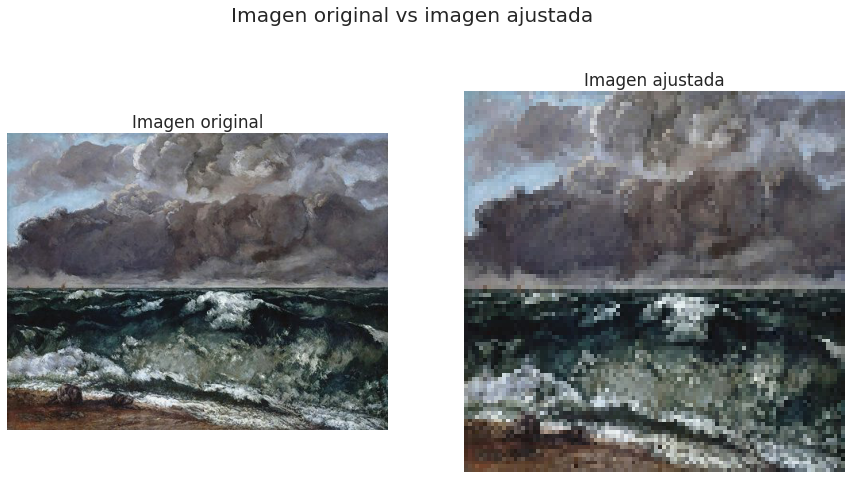

In [213]:
compara_muestras(x_train_original, x_train_resized)

# DataAugmentation

Establecemos los parametros para la creación de nuevas imagenes a partir de modificaciones de la original. Estas variaciones permiten aprovechar cada parte de la imagen para encontrar los patrones, es muy útil cuando tenemos pocas imágenes. Podemos realizar las siguientes modificaciones:
* **rotation_range**: Indica el numero maximo de grados que la imagen se puede inclinar.
* **width shift range, height shift range**: cambia de orientación los pixeles de algunas partes de la imagen.
* **shear_range**: Modifica algunas partes de la imagen modificando la orientación.
* **zoom_range**: Aplica un acercamiento a la imagen.
* **horizontal_flip**: Cambia la orientación de la imagen.
* **fill_mode**: Cuando a la imagen se le aplica una rotación cambia su aspecto, para mantener el mismo aspecto se tienen que rellenar los pixeles faltantes, con la opción nearest los pixeles cercanos se repiten para rellenar las areas faltantes.

In [52]:
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

In [247]:
x_train = train_generator.flow(x_train_resized)

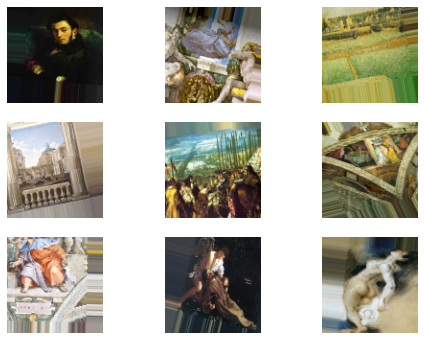

In [266]:
for i in range(9):

    plt.subplot(330 + 1 + i)
    batch = x_train.next()
    image = batch[0].astype('uint8')
    plt.axis('Off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()


In [274]:
x_train = x_train_resized

# Empecemos

## Algunas consideraciones previas

Antes de ponernos a probar modelos estableceremos nuestros objetivos en los resultados. Para ello definiremos las métricas que nos indicarán si nuestro modelo está haciendo bien el trabajo. Empezamos por definir los indicadores:


**Métricas de evaluación del modelo**:

* **loss**: Por lo general, con las redes neuronales, buscamos minimizar el error. Como tal, la función objetivo a menudo se denomina función de costo o función de pérdida y el valor calculado por la función de pérdida.
* **mse**: El *error cuadrático medio* (median standard error)es una función de coste se pueden utilizar métodos estadísticos formales para determinar la confianza del modelo entrenado. 

* **acurracy**: La exactitud mide el porcentaje de casos en los que el modelo a acertado. Es una medida que puede indicar buenos resultados pero no que se trate de un buen modelo sobretodo cuando las clases están desbalanceadas. Se mide dividiendo la suma de los verdaderos positivos y los verdaderos negativos entre la suma de los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
* **precision**: La precisión mide la **calidad** del modelo. Es el resultado de dividir los verdaderos positivos entre la suma de los verdaderos positivos y los falsos positivos.
* **recall**: La exhaustividad nos aporta información sobre la **cantidad** de elementos que es capaz de identificar. Es el número de resultante de dividir los verdaderos positivos entre la suma de los verdaderos positivos y los falsos negativos.
* **f1**: El Valor-F combina las medidas de precisión y recall en un solo valor, siendo el resultado de multiplicar por dos el producto de la precision y el recall entre la suma de los mismos.

**Hiperparametros a tener en cuenta**:

* **Batch**: Con el *bach* definimos el número de muestras para trabajar antes de actualizar los paramétros internos del modelo. Las predicciones se comparan con las variables de salidad esperadas y se calcula el error. A partir de este error el algoritmo se actualiza para mejorarse.

    * **Batch Gradient Descent**. Cuando el tamaño del bach es igual que el del conjunto de entrenamiento
    * **Stochastic Gradient Descent**. Cuando el tamaño del bach es igual a 1.
    * **Mini-Batch Gradient Descent**. Cuando el tamaño del bach está entre uno y el tamaño del conjunto de entrenamient, los más frecuentes en tutoriales son de  32, 64 y 128.
    
    
* **Epoch**: Se trata de un hiperparámetro que define el número de veces que el algoritmo de aprendizaje funcionará sobre el conjunto de datos de entrenamiento. Cada muestra del conjunto de datos de entrenamiento tiene la "oportunidad" de actualizar los parámetros internos del modelo. Puede estar compuesto por uno o más *batches*. El número de *epochs* suele ser grande, lo que permite que el algoritmo se ejecute hasta que el error del modelo se minimice lo suficiente.

## Funciones

In [226]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show() 

In [227]:
def plot_train_vs_test (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, epochs, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, epochs, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [228]:
def plot_roc(model_pred):
    
    """
    **************************************************************
    
    
    
    ***************************************************************
    """

    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()  
    tpr = dict()  
    roc_auc = dict()  
    for i in range(num_classes):  
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), model_pred.ravel())  
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)  
    for i in range(num_classes):  
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr  
    tpr["macro"] = mean_tpr  
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(3), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2)  
    plt.xlim(0, 0.2)  
    plt.ylim(0.8, 1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(3), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show() 

In [229]:
def test_img(model_predicted):
    
    """
    **************************************************************
    
    Devuelve una imagen con el resultado del modelo de predicción
    indicado.
    
    Input:
    -model_predicted: resultados del modelo con el test.
    
    Output:
    -Imagen con la predicción
    
    
    ***************************************************************
    """
    
    
    #Generamos la elección aleatoria de la imagen
    num = random.Random(range(0, len(model_predicted)))
    
    #Imprimimos la imagen
    plt.imshow(cv2.cvtColor(x_test_original[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    #Muestra la etiqueta real y la predicha.
    print('class for image 1: ' + str(np.argmax(y_test[0])))  
    print('predicted:         ' + str(model_predicted[0])) 

In [230]:
K.set_image_data_format('channels_last')  

In [231]:
K.set_learning_phase(1) 

# Red Neuronal Simple

Empezaremos definiendo una red neuronal simple y junto con ella, algunos conceptos que se irán repitiendo a medida que vayamos viendo diferentes modelos:
* **Flatten**: Convierte la matriz de entrada en un array de 1 dimensión, en un array plano.
+ **Dense**: Añade una capa oculta la red neuronal.

**Función de activación ReLu**: Transforma los valores introducidos anulando los valores negativos y dejando los positivos tal y como entran. La ventaja de usar la función ReLU radica en que no posee regiones de saturación dado que tiene un comportamiento lineal para entradas positivas, lo que evita precisamente este "estancamiento" durante el entrenamiento.

**Función de salida SoftMax**: Cuando el entrenamiento es multietiqueta pero no multiclase, tenemos muchos artistas diferentes pero solo pinturas. Asigna probabilidades decimales a cada clase en un caso de clases múltiples. Esas probabilidades decimales deben sumar 1.0. Esta restricción adicional permite que el entrenamiento converja más rápido.

In [276]:
def create_simple_nn(): 
    
    model = Sequential()
    model.add(Flatten(input_shape=x_train[0].shape, name="Input_layer"))
    model.add(Dense(100, activation='relu', name="Hidden_layer_1"))
    model.add(Dense(50, activation='relu', name="Hidden_layer_2"))
    model.add(Dense(num_classes, activation='softmax', name="Output_layer"))

    return model

In [277]:
snn_model = create_simple_nn()  

Definimos nuestra función de pérdida en <code>loss</code> entre las opciones:
* <code>'categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>OneHotEncoding</code>.
* <code>'sparse_categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>LabelEncoder</code>.

Para nuestro <code>optimizer</code> usaremos:
* <code>'Adam'</code>: implementa el algoritmo Adam. Se trata de un método de descenso de gradiente estocástico que se basa en la estimación adaptativa. Se trara de un método computacionalmente eficiente y con pocos requisitos de memoria y adecuado para problemas con grandes cantidades de datos/parámetros.

En cuanto a nuestras métricas, en <code>metrics</code> nos centraremos, como hemos comentado más arriba, en el accuracy y el error cuadrático.

In [278]:
snn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

Con <code>.summary()</code> podemos ver un resumen de nuestra red neuronal.

In [279]:
snn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 30000)             0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 100)               3000100   
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 50)                5050      
_________________________________________________________________
Output_layer (Dense)         (None, 10)                510       
Total params: 3,005,660
Trainable params: 3,005,660
Non-trainable params: 0
_________________________________________________________________


Podemos observar que tiene un total  de **3 millones de parámetros**.

## Parámetros

Para las funciones de <code>callback</code> usaremos:

* **EarlyStopping**: Para el entreno cuando la función de coste no mejora en un número dado de epochs reduciendo el **overfitting**. Para ello le indicamos <code>verbose</code> en 1, para saber el epoch en el que el modelo se ha parado. con <code>patience</code> le indicamos cuantos epochs tienen que pasar para que el entrenamiento pare y con <code>min_delta</code> establecemos un incremento especifico de la mejora para el error cuadrático.


* **ReduceLROnPlateau**: Si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo, lo que normalmente obtiene una mejora del entrenamiento.

In [280]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks = [early_stop, reduce_lr] 

## Entrenar el modelo

Ahora ya solo queda entrenarla, para ello le indicamos nuestras imágenes, los pintores y los parámetros que hemos establecido antes.

In [281]:
epochs = 30
bach_size = 32

In [282]:
snn = snn_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=bach_size),
    steps_per_epoch=len(x_train) // bach_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_test, y_test),
    shuffle=True) 

Epoch 1/30
11/11 [==============================] - 2s 150ms/step - loss: 1365.4118 - acc: 0.0971 - mse: 0.1800 - val_loss: 650.4789 - val_acc: 0.1562 - val_mse: 0.1688
Epoch 2/30
11/11 [==============================] - 2s 190ms/step - loss: 827.8056 - acc: 0.1000 - mse: 0.1798 - val_loss: 646.8989 - val_acc: 0.0521 - val_mse: 0.1887
Epoch 3/30
11/11 [==============================] - 2s 204ms/step - loss: 423.1351 - acc: 0.1714 - mse: 0.1649 - val_loss: 340.0748 - val_acc: 0.1250 - val_mse: 0.1745
Epoch 4/30
11/11 [==============================] - 2s 204ms/step - loss: 247.1239 - acc: 0.1629 - mse: 0.1660 - val_loss: 258.8635 - val_acc: 0.2188 - val_mse: 0.1554
Epoch 5/30
11/11 [==============================] - 2s 205ms/step - loss: 204.3005 - acc: 0.1449 - mse: 0.1697 - val_loss: 182.8853 - val_acc: 0.1979 - val_mse: 0.1595
Epoch 6/30
11/11 [==============================] - 2s 218ms/step - loss: 169.0729 - acc: 0.1657 - mse: 0.1651 - val_loss: 227.6309 - val_acc: 0.1458 - val_mse

## Evaluación del modelo

In [283]:
evaluation = snn_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=bach_size), verbose=1) 
evaluation

12/12 [==============================] - 2s 166ms/step


[18.97376251220703, 0.22513088583946228, 0.14679500460624695]

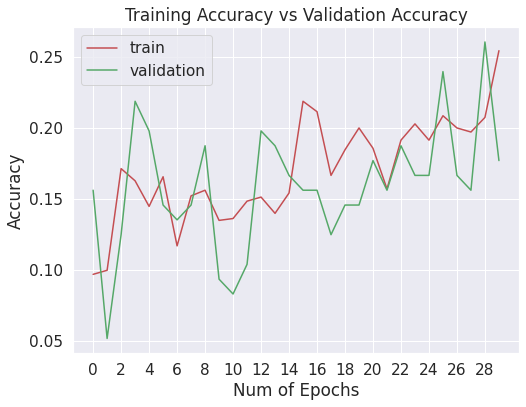

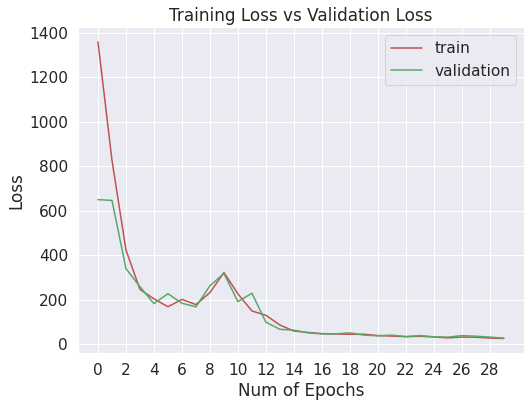

In [284]:
plot_train_vs_test(snn)

## Predicción del modelo

In [285]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1) 

96/96 [==============================] - 0s 760us/step


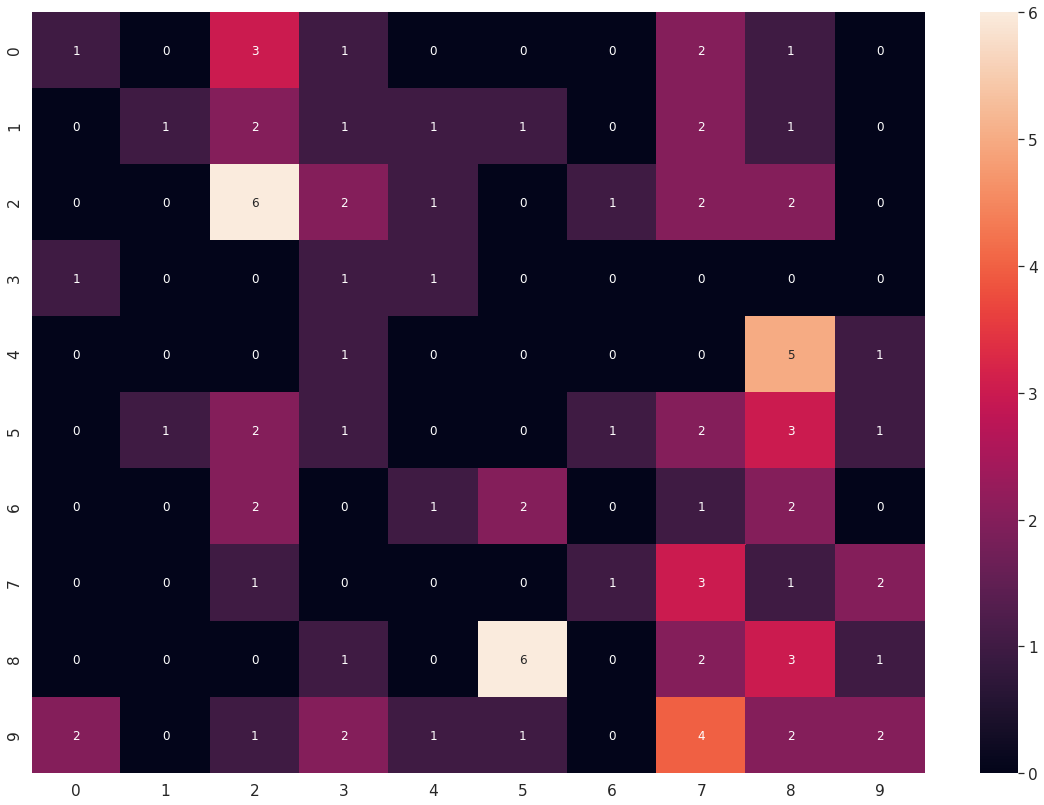

In [286]:
conf_matrix(num_classes, snn_predicted)

In [287]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.50      0.11      0.18         9
           2       0.35      0.43      0.39        14
           3       0.10      0.33      0.15         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           7       0.17      0.38      0.23         8
           8       0.15      0.23      0.18        13
           9       0.29      0.13      0.18        15

    accuracy                           0.18        96
   macro avg       0.18      0.17      0.15        96
weighted avg       0.20      0.18      0.16        96



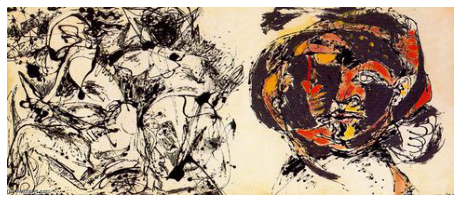

class for image 1: 6
predicted:         5


In [288]:
test_img(snn_predicted)

## Guardar el histórico

Guardamos el histórico del modelo en un archivo <code>pickle</code>.

In [197]:
with open('simplenn_history.txt', 'wb') as file_pi:  
  pickle.dump(snn.history, file_pi)

# Convultional Nets

Las neuronas de las redes neuronales convolucionales corresponden a campos receptivos de las neuronas de la corteza visual de un cerebro biológico. Han demostrado ser buenas para reconocer objetos en una imagen dado que permiten aprovecharla por trozos.
En este caso veremos los siguientes conceptor nuevos:

* **Conv2D**: Introduce una red convolucional, esta realiza el proceso de mover el kernel por toda la imagen y multiplicar los valores que encuentra. Tenemos que indicarle como primer parámetro el número de kernels, después el tamaño de estos, el tamaño del input y el tipo de activación que queremos.
* **MaxPooling2D**: Para esta capa pasamos un kernel vacio, pero en vez de multiplicar la información, toma el valor más grande de la sección de la imagen. Con <code>pool_size</code> le indicamos el tamaño del kernel que usará esta capa.
* **Dropout**: Nos permite hacer redes con más capas.


In [289]:
def create_simple_cnn(): 
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=x_train[0].shape, activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [290]:
scnn_model = create_simple_cnn()  
scnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

In [291]:
scnn_model.summary() 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 46, 46, 128)       73856     
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 44, 44, 256)       295168    
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 42, 42, 512)       1180160   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 21, 512)     

Vemos como esta red neuronal propone entrenar más de 47 millones de parámetros frente a los 3 millones de la red simple.

## Entrenar el modelo

In [292]:
scnn = scnn_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=bach_size),
    steps_per_epoch=len(x_train) // bach_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_test, y_test),
    shuffle=True) 

Epoch 1/30
11/11 [==============================] - 65s 6s/step - loss: 51.8871 - acc: 0.1165 - mse: 0.1215 - val_loss: 2.2889 - val_acc: 0.1042 - val_mse: 0.0897
Epoch 2/30
11/11 [==============================] - 63s 6s/step - loss: 2.2895 - acc: 0.1466 - mse: 0.0899 - val_loss: 2.3115 - val_acc: 0.0938 - val_mse: 0.0902
Epoch 3/30
11/11 [==============================] - 64s 6s/step - loss: 2.3001 - acc: 0.1114 - mse: 0.0900 - val_loss: 2.3372 - val_acc: 0.1354 - val_mse: 0.0906
Epoch 4/30
11/11 [==============================] - 65s 6s/step - loss: 2.2703 - acc: 0.1571 - mse: 0.0894 - val_loss: 2.2522 - val_acc: 0.1458 - val_mse: 0.0889
Epoch 5/30
11/11 [==============================] - 63s 6s/step - loss: 2.2926 - acc: 0.1486 - mse: 0.0899 - val_loss: 2.3755 - val_acc: 0.1042 - val_mse: 0.0911
Epoch 6/30
11/11 [==============================] - 64s 6s/step - loss: 2.2571 - acc: 0.1457 - mse: 0.0892 - val_loss: 2.2895 - val_acc: 0.1458 - val_mse: 0.0897
Epoch 7/30
11/11 [=========

In [293]:
cnn_evaluation = scnn_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=bach_size), verbose=1) 
cnn_evaluation

12/12 [==============================] - 19s 2s/step


[2.2875373363494873, 0.1256544440984726, 0.08969516307115555]

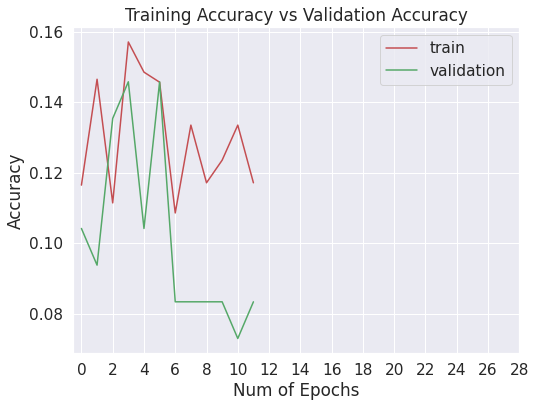

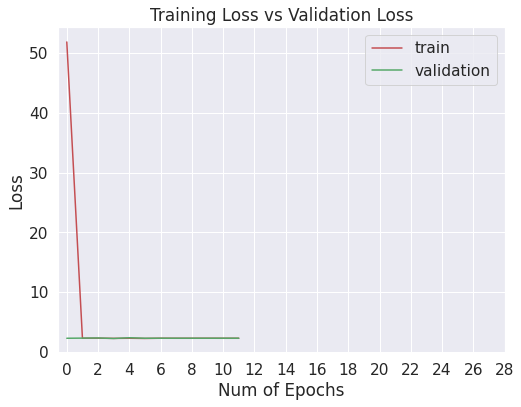

In [294]:
plot_train_vs_test(scnn)

In [295]:
scnn_pred = scnn_model.predict(x_test, batch_size=32, verbose=1)  
scnn_predicted = np.argmax(scnn_pred, axis=1)

96/96 [==============================] - 5s 48ms/step


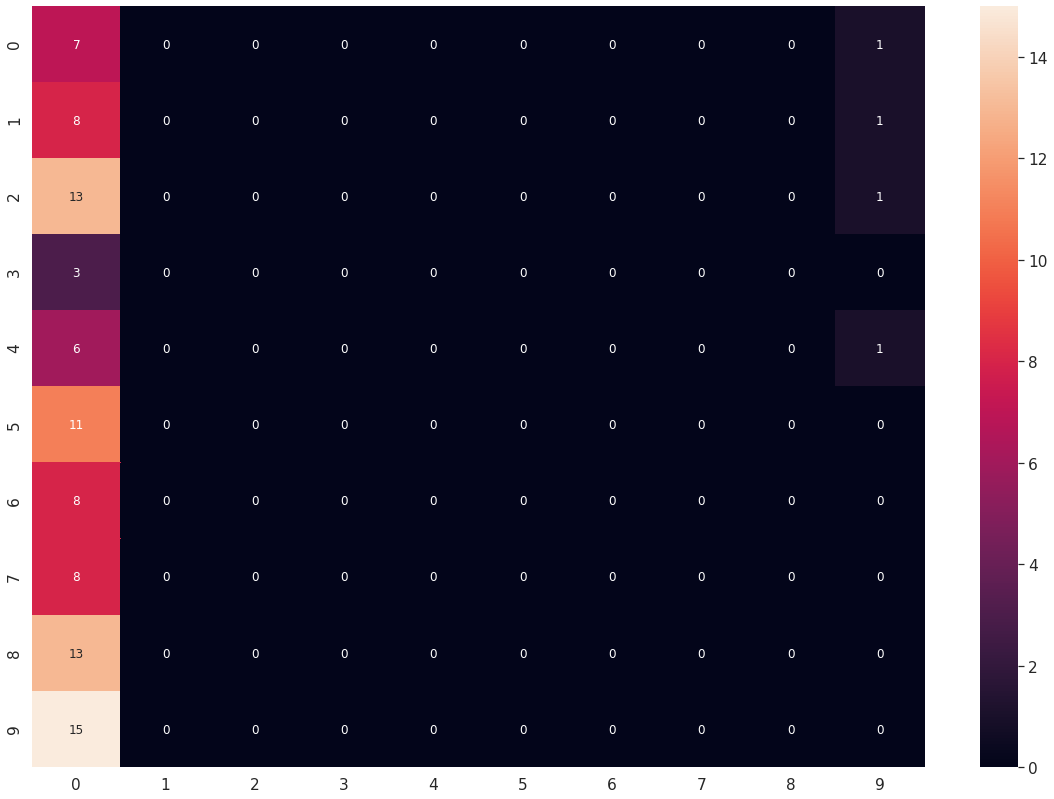

In [296]:
conf_matrix(num_classes, scnn_predicted) 

In [297]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted)  
print(scnn_report) 

              precision    recall  f1-score   support

           0       0.08      0.88      0.14         8
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        15

    accuracy                           0.07        96
   macro avg       0.01      0.09      0.01        96
weighted avg       0.01      0.07      0.01        96



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


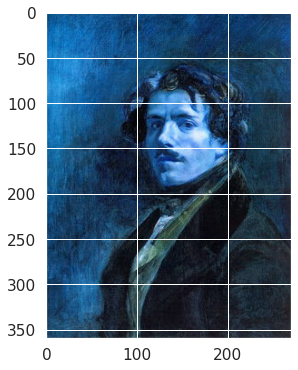

class for image 1: 9
predicted:         0


In [298]:
imgplot = plt.imshow(x_train_original[5])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[5])))  
print('predicted:         ' + str(scnn_predicted[5])) 

In [299]:
#Histórico
with open('scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

# VGG-16 

Seguimos los mismos casos que con los modelos anteriores. Para este caso tendremos en cuenta los siguientes parámetros:
* **include_top**: añade una red neuronal densa al final.
* **weights**: no cargaremos ningún modelo entrenado previamente como si haremos más adelante.
* **input_tensor**:no especificaremos ningún tensor de keras.
* **input_shape**:define la dimensión de los datos de entrada.
* **pooling**: no lo especificamos.
* **classes**: le indicamos el número de clases.

In [238]:
def create_vgg16():  
  model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=num_classes)

  return model

In [239]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

Echamos un vistazo al modelo que hemos creado

In [240]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Tenemos más de **50 millones de parámetros** para entrenar. Frente a los 3 millones de nuestra red neuronal simple o los 47 de la red convolucional.

In [241]:
vgg16 = vgg16_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=bach_size),
    steps_per_epoch=len(x_train) // bach_size,
    epochs=epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data=(x_test, y_test),
    shuffle=True)

Epoch 1/100
11/11 [==============================] - 55s 5s/step - loss: 31.7070 - acc: 0.1171 - mse: 0.0970 - val_loss: 2.2971 - val_acc: 0.1146 - val_mse: 0.0900
Epoch 2/100
11/11 [==============================] - 53s 5s/step - loss: 2.3246 - acc: 0.1257 - mse: 0.0902 - val_loss: 2.2881 - val_acc: 0.1562 - val_mse: 0.0897
Epoch 3/100
11/11 [==============================] - 53s 5s/step - loss: 2.2700 - acc: 0.1364 - mse: 0.0894 - val_loss: 2.2741 - val_acc: 0.1458 - val_mse: 0.0894
Epoch 4/100
11/11 [==============================] - 51s 5s/step - loss: 2.2646 - acc: 0.1379 - mse: 0.0893 - val_loss: 2.2627 - val_acc: 0.1146 - val_mse: 0.0893
Epoch 5/100
11/11 [==============================] - 52s 5s/step - loss: 2.3355 - acc: 0.1165 - mse: 0.0902 - val_loss: 2.2878 - val_acc: 0.0833 - val_mse: 0.0897
Epoch 6/100
11/11 [==============================] - 51s 5s/step - loss: 2.2718 - acc: 0.1178 - mse: 0.0894 - val_loss: 2.2864 - val_acc: 0.0833 - val_mse: 0.0897
Epoch 7/100
11/11 [==

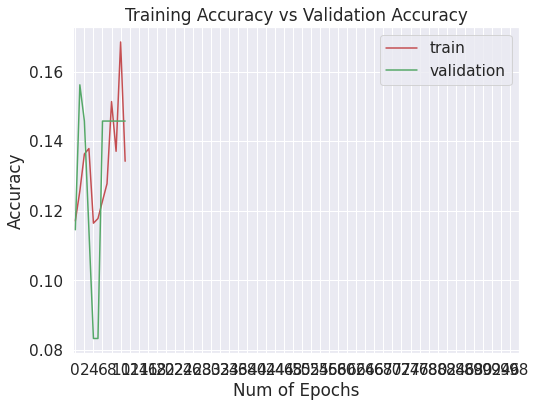

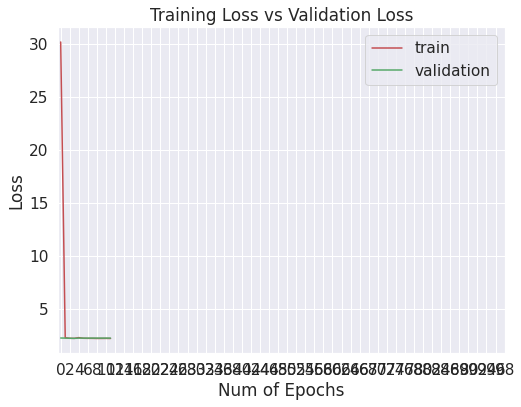

In [242]:
plot_train_vs_test(vgg16)

In [243]:
vgg16_pred = vgg16_model.predict(x_test, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

96/96 [==============================] - 3s 30ms/step


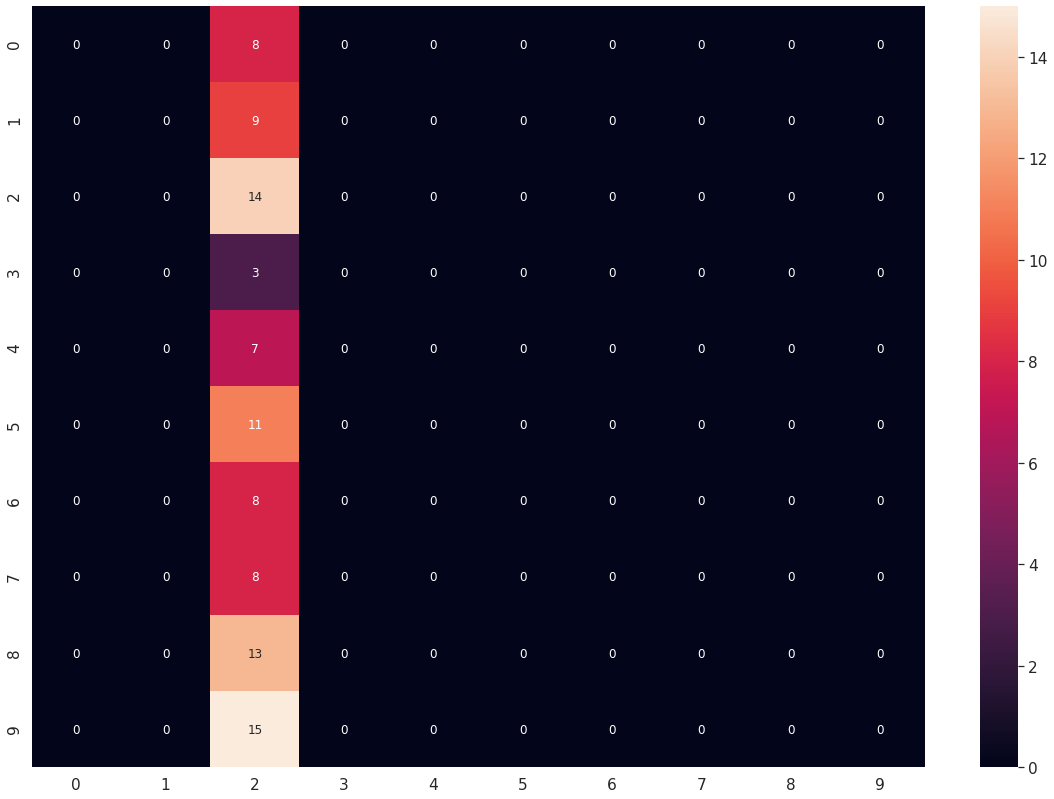

In [244]:
conf_matrix(num_classes, vgg16_predicted)

In [245]:
vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted)  
print(vgg16_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         9
           2       0.15      1.00      0.25        14
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        15

    accuracy                           0.15        96
   macro avg       0.01      0.10      0.03        96
weighted avg       0.02      0.15      0.04        96



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


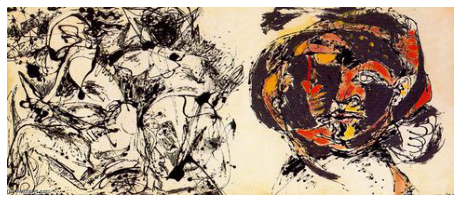

class for image 1: 6
predicted:         2


In [246]:
test_img(vgg16_predicted)

In [ ]:
#Histórico
with open('vgg16_history.txt', 'wb') as file_pi:  
    pickle.dump(vgg16.history, file_pi)

# DenseNet121

In [300]:
def build_DenseNet_model():  
    base_model = densenet.DenseNet121(input_shape=x_train[0].shape,
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [301]:
densenet_model = build_DenseNet_model()  
densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

In [302]:
densenet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 106, 106, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
densenet = densenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks = callbacks_list,
    shuffle=True)

Epoch 1/30
11/11 [==============================] - 126s 11s/step - loss: 593.4673 - acc: 0.1029 - mse: 0.0943 - val_loss: 411.9990 - val_acc: 0.1146 - val_mse: 0.0899
Epoch 2/30
11/11 [==============================] - 38s 3s/step - loss: 375.5595 - acc: 0.1429 - mse: 0.0895 - val_loss: 336.3438 - val_acc: 0.1562 - val_mse: 0.0898
Epoch 3/30
11/11 [==============================] - 39s 4s/step - loss: 308.7914 - acc: 0.1314 - mse: 0.0897 - val_loss: 278.8371 - val_acc: 0.2292 - val_mse: 0.0895
Epoch 4/30
11/11 [==============================] - 39s 4s/step - loss: 257.7898 - acc: 0.1571 - mse: 0.0895 - val_loss: 234.6698 - val_acc: 0.2188 - val_mse: 0.0897
Epoch 5/30
11/11 [==============================] - 39s 4s/step - loss: 219.1119 - acc: 0.1875 - mse: 0.0896 - val_loss: 202.6543 - val_acc: 0.2188 - val_mse: 0.0897
Epoch 6/30
11/11 [==============================] - 40s 4s/step - loss: 190.8177 - acc: 0.1343 - mse: 0.0897 - val_loss: 176.8034 - val_acc: 0.2396 - val_mse: 0.0898
Ep

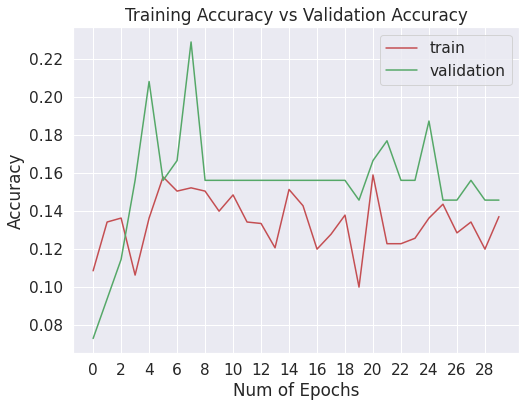

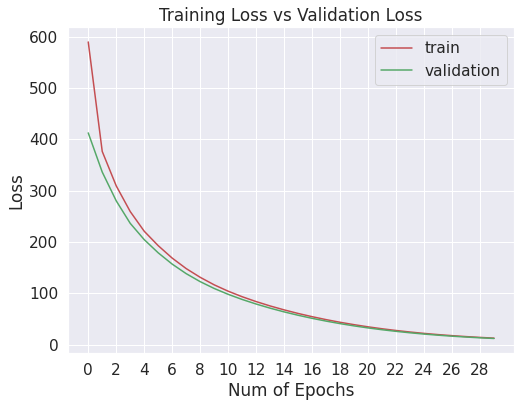

In [135]:
plot_train_vs_test(densenet)

In [136]:
densenet_pred = densenet_model.predict(x_test, batch_size=32, verbose=1)  
densenet_predicted = np.argmax(densenet_pred, axis=1)  

96/96 [==============================] - 10s 99ms/step


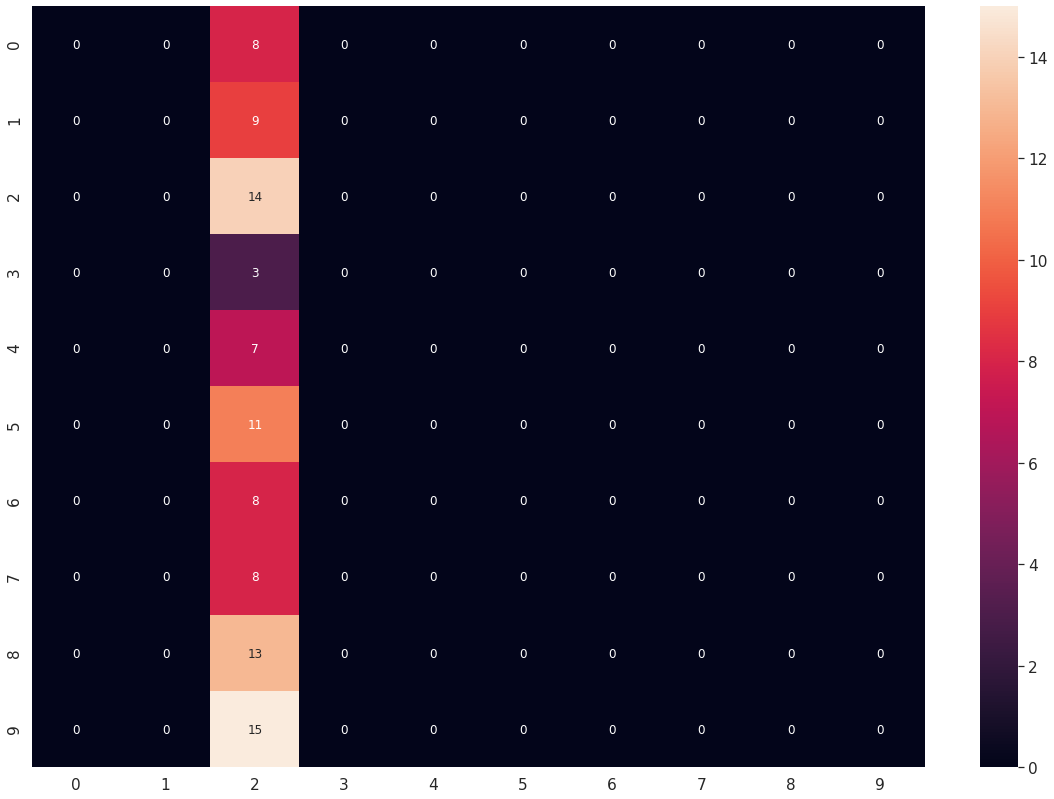

In [137]:
conf_matrix(num_classes, densenet_predicted)

In [138]:
densenet_report = classification_report(np.argmax(y_test, axis=1), densenet_predicted)  
print(densenet_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         9
           2       0.15      1.00      0.25        14
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        15

    accuracy                           0.15        96
   macro avg       0.01      0.10      0.03        96
weighted avg       0.02      0.15      0.04        96



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_roc(densenet_pred)

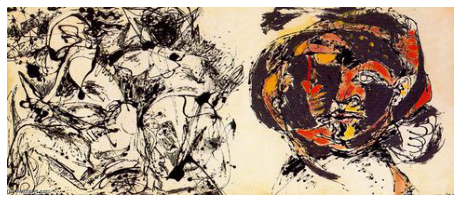

class for image 1: 6
predicted:         2


In [139]:
test_img(vgg16_predicted)

In [ ]:
#Histórico
with open('densenet_history.txt', 'wb') as file_pi:  
    pickle.dump(densenet.history, file_pi)

# ImageNet

En este caso usaremos la red pre-entrenada *IncepcionResNetV2* con  *ImageNet*. Intentaremos ajustarla para ver que resultados nos da con nuestro dataset. Usaremos métodos de *fine-tuning* para ahorrar en nuestros recursos de computación y evitarnos la mayor parte del tiempo de entreno.

In [140]:
imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)

In [141]:
x = imagenet_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x) 
imagenet_model = Model(input=imagenet_model.input, output=predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [142]:
LAYERS_TO_FREEZE=700

In [143]:
for layer in imagenet_model.layers[:LAYERS_TO_FREEZE]:
    layer.trainable = False

In [144]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [145]:
#imagenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [151]:
imagenet = imagenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/30
11/11 [==============================] - 17s 2s/step - loss: 1.2626 - acc: 0.5914 - mse: 0.0542 - val_loss: 1.7577 - val_acc: 0.5417 - val_mse: 0.0667
Epoch 2/30
11/11 [==============================] - 16s 1s/step - loss: 1.1689 - acc: 0.6023 - mse: 0.0517 - val_loss: 1.7342 - val_acc: 0.5104 - val_mse: 0.0689
Epoch 3/30
11/11 [==============================] - 18s 2s/step - loss: 0.9243 - acc: 0.7328 - mse: 0.0405 - val_loss: 1.6486 - val_acc: 0.5208 - val_mse: 0.0643
Epoch 4/30
11/11 [==============================] - 18s 2s/step - loss: 1.0608 - acc: 0.6800 - mse: 0.0469 - val_loss: 1.8105 - val_acc: 0.5000 - val_mse: 0.0711
Epoch 5/30
11/11 [==============================] - 18s 2s/step - loss: 1.0720 - acc: 0.6534 - mse: 0.0461 - val_loss: 1.8003 - val_acc: 0.4792 - val_mse: 0.0699
Epoch 6/30
11/11 [==============================] - 17s 2s/step - loss: 0.8933 - acc: 0.7241 - mse: 0.0399 - val_loss: 1.7667 - val_acc: 0.5312 - val_mse: 0.0651
Epoch 7/30
11/11 [==========

In [152]:
imagenet_pred = imagenet_model.predict(x_test, batch_size=bach_size, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1)  

96/96 [==============================] - 13s 133ms/step


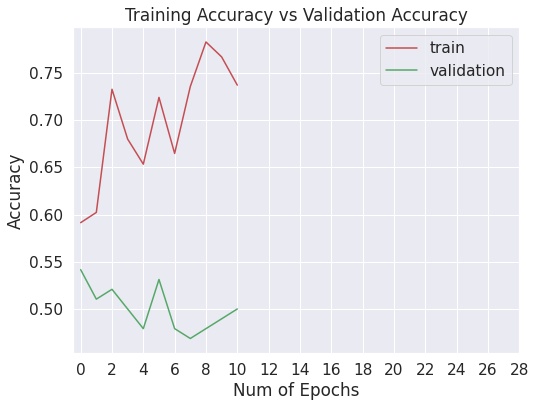

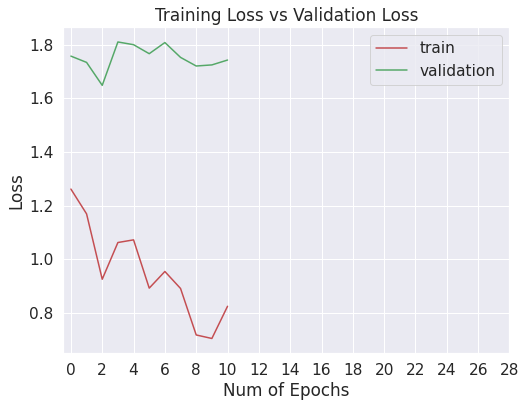

In [157]:
plot_train_vs_test(imagenet)

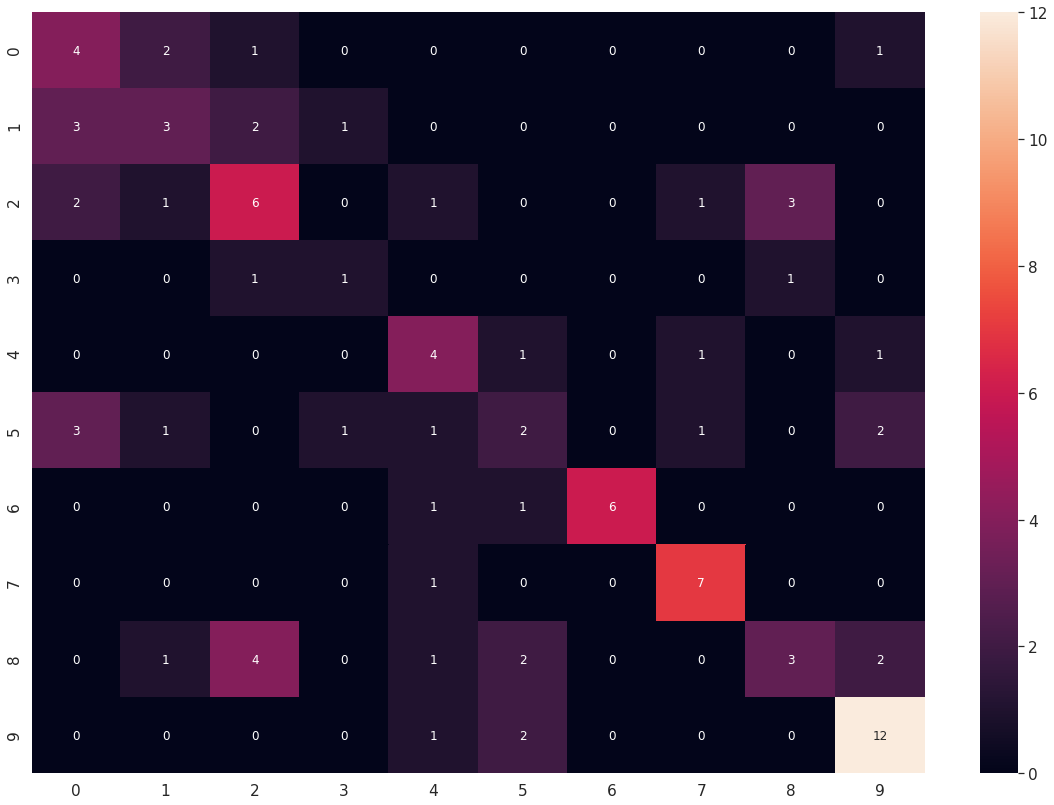

In [154]:
conf_matrix (num_classes, imagenet_predicted)

In [155]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted)  
print(imagenet_report)

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         8
           1       0.38      0.33      0.35         9
           2       0.43      0.43      0.43        14
           3       0.33      0.33      0.33         3
           4       0.40      0.57      0.47         7
           5       0.25      0.18      0.21        11
           6       1.00      0.75      0.86         8
           7       0.70      0.88      0.78         8
           8       0.43      0.23      0.30        13
           9       0.67      0.80      0.73        15

    accuracy                           0.50        96
   macro avg       0.49      0.50      0.49        96
weighted avg       0.50      0.50      0.49        96



In [ ]:
plot_roc(imagenet_pred)

In [ ]:
test_img(imagenet_predicted)

In [156]:
#Modelo
imagenet_model.save('imagenet.h5')

#Histórico
with open('imagenet_history.txt', 'wb') as file_pi:  
  pickle.dump(imagenet.history, file_pi)

# NASNet

La arquitectura NASNet se compone de dos tipos de capas: La capa normal , y la capa de reducción. Ambas capas fueron diseñadas por AutoML.

In [158]:
def create_nasnet():  
  model = nasnet.NASNetMobile(input_shape=x_train[0].shape, include_top=True, weights=None, input_tensor=None, pooling=None, classes=num_classes)

  return model

In [159]:
nasnet_model = create_nasnet()  
nasnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

In [160]:
nasnet_model.summary()  

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 49, 49, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 49, 49, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 49, 49, 32)   0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [163]:
epochs = 30
batch_size = 32

In [164]:
nasnet = nasnet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/30
11/11 [==============================] - 265s 24s/step - loss: 2.4816 - acc: 0.2200 - mse: 0.0910 - val_loss: 1.9315 - val_acc: 0.3229 - val_mse: 0.0797
Epoch 2/30
11/11 [==============================] - 64s 6s/step - loss: 1.8669 - acc: 0.3314 - mse: 0.0782 - val_loss: 1.6242 - val_acc: 0.4271 - val_mse: 0.0687
Epoch 3/30
11/11 [==============================] - 59s 5s/step - loss: 1.6668 - acc: 0.4457 - mse: 0.0715 - val_loss: 1.7805 - val_acc: 0.4792 - val_mse: 0.0725
Epoch 4/30
11/11 [==============================] - 59s 5s/step - loss: 1.5031 - acc: 0.4971 - mse: 0.0652 - val_loss: 1.7387 - val_acc: 0.4375 - val_mse: 0.0732
Epoch 5/30
11/11 [==============================] - 61s 6s/step - loss: 1.4371 - acc: 0.5029 - mse: 0.0643 - val_loss: 2.0379 - val_acc: 0.3854 - val_mse: 0.0830
Epoch 6/30
11/11 [==============================] - 61s 6s/step - loss: 1.5237 - acc: 0.5200 - mse: 0.0664 - val_loss: 1.8167 - val_acc: 0.4271 - val_mse: 0.0782

Epoch 00006: ReduceLROnPl

96/96 [==============================] - 13s 136ms/step


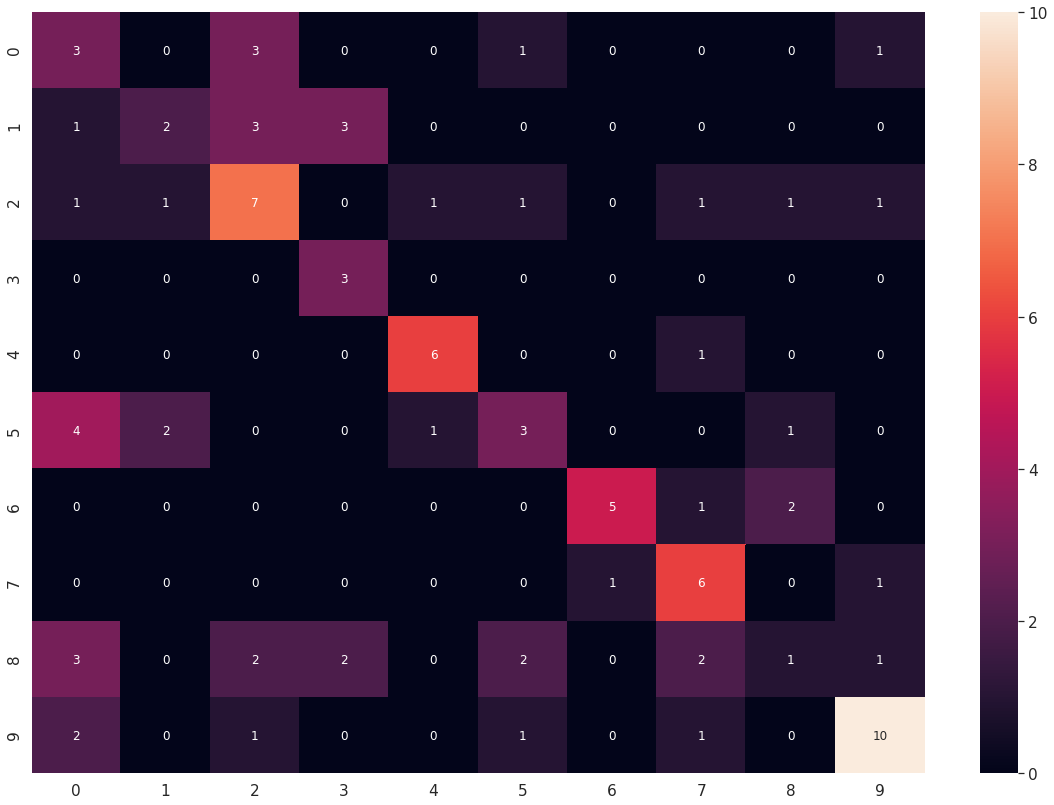

In [166]:
nasnet_pred = nasnet_model.predict(x_test, batch_size=batch_size, verbose=1)  
nasnet_predicted = np.argmax(nasnet_pred, axis=1)

conf_matrix(num_classes, nasnet_predicted) 

In [167]:
nasnet_report = classification_report(np.argmax(y_test, axis=1), nasnet_predicted)  
print(nasnet_report)

              precision    recall  f1-score   support

           0       0.21      0.38      0.27         8
           1       0.40      0.22      0.29         9
           2       0.44      0.50      0.47        14
           3       0.38      1.00      0.55         3
           4       0.75      0.86      0.80         7
           5       0.38      0.27      0.32        11
           6       0.83      0.62      0.71         8
           7       0.50      0.75      0.60         8
           8       0.20      0.08      0.11        13
           9       0.71      0.67      0.69        15

    accuracy                           0.48        96
   macro avg       0.48      0.53      0.48        96
weighted avg       0.48      0.48      0.46        96



In [168]:
#Modelo
nasnet_model.save('nasnet.h5')

#Histórico
with open('nasnet_history.txt', 'wb') as file_pi:  
  pickle.dump(nasnet.history, file_pi)

# Comparativa

In [ ]:
with open(path_base + '/simplenn_history.txt', 'rb') as f:  
  snn_history = pickle.load(f)

In [ ]:
with open(path_base + '/scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

In [ ]:
with open(path_base + '/vgg16_history.txt', 'rb') as f:  
  vgg16_history = pickle.load(f)

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16_history['val_acc'],'b')  
plt.plot(vgg19.history['val_acc'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN', 'VGG 16'])

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn.history['val_mean_squared_error'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN', 'VGG 16'])  